# Comparative sentiment analysis: LSTM VS Transfomer for IMDB movies reviews
## Research question: Is the training data input order affect sentiment analysis performance using LSTM and BERT models? 

### Project imports

In [5]:
# EDA and Preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from collections import Counter
import contractions
# nltk related
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
# Models building, training, and evaluation
from gensim.models import Word2Vec
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# transformers
from transformers import AutoTokenizer
from transformers import TFDistilBertForSequenceClassification, create_optimizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erez1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erez1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erez1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\erez1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [6]:
reviews_data = pd.read_csv('IMDB Dataset.csv')
reviews_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Dataset Cleaning and some basic EDA

In [7]:
reviews_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
reviews_data[reviews_data['review'].duplicated() == True]

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


In [6]:
reviews_data.drop_duplicates(subset='review', inplace=True)

In [7]:
reviews_data['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

## I'll take as a balanced sample from the dataset: 5,000 positive and 5,000 negative reviews

In [ ]:
positive_reviews = reviews_data[reviews_data['sentiment'] == 'positive'].sample(n=5000, random_state=42)
negative_reviews = reviews_data[reviews_data['sentiment'] == 'negative'].sample(n=5000, random_state=42)
balanced_reviews = pd.concat([positive_reviews, negative_reviews]).sample(frac=1.0, random_state=42).reset_index(drop=True)

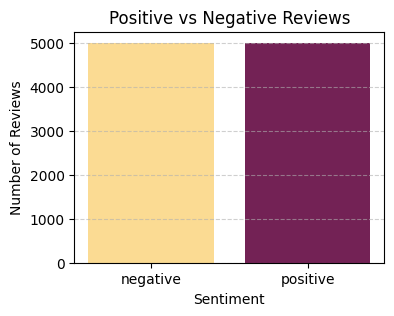

In [ ]:
label_counts = balanced_reviews['sentiment'].value_counts()

plt.figure(figsize=(4, 3))
plt.bar(label_counts.index, label_counts.values, color=['#FBDB93', '#732255'])
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Positive vs Negative Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

### Reviews text cleaning
Cleaning from html tags like <> displayed on the head and more

In [10]:
# Remove HTML tags, URLs, and extra spaces
def clean_text(text):  
    text = re.sub(r'<.*?>', '', text)   
    text = re.sub(r'https?://\S+', '', text)   
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()

In [11]:
cleaned_reviews = balanced_reviews['review'].apply(clean_text)
cleaned_reviews.head()

0    "electra glide in blue" is a slow moving b-fli...
1    an extremely powerful film that certainly isn'...
2    i am not going to lie. despite looking interes...
3    one of the first of the best musicals, anchors...
4    i rank opera as one of the better argento film...
Name: review, dtype: object

### Tokenization
- NLTK's word_tokenize() is used to split text into words and punctuation using the Penn Treebank tokenizer under the hood.
- NLTK's stopwords.words('english') gives a standard set of English stopwords. These are common function words (like "the", "is", "and") that usually don’t contribute meaningful information for models like LSTM or BERT.

In [12]:
stop_words = set(stopwords.words('english'))

def tokenize(text):
    expanded = contractions.fix(text)  # Relevant to expand "didn't" to "did not" so we will not have n't as a seperate token later..
    tokens = word_tokenize(expanded)
    return [
        t.lower() for t in tokens 
        if t.lower() not in stop_words 
        and t not in string.punctuation 
        and len(t.strip()) > 1 
        and not re.match(r'^``|\'\'|\'s|\'$', t)
    ]

In [13]:
tokenized_reviews = cleaned_reviews.apply(tokenize)
tokenized_reviews.head()

0    [electra, glide, blue, slow, moving, b-flick, ...
1    [extremely, powerful, film, certainly, appreci...
2    [going, lie, despite, looking, interesting, wa...
3    [one, first, best, musicals, anchors, aweigh, ...
4    [rank, opera, one, better, argento, films, plo...
Name: review, dtype: object

In [14]:
# print the top 10 frequent tokens
all_tokens = [token for review in tokenized_reviews for token in review]
token_counts = Counter(all_tokens)
top_10 = token_counts.most_common(10)

for word, freq in top_10:
    print(f"{word}: {freq}")

movie: 17230
film: 15486
one: 10384
like: 7907
would: 6275
good: 5682
even: 4982
time: 4720
really: 4639
see: 4538


### lemmatization 
- I'll use NLTK's WordNetLemmatizer to reduce words to their base or dictionary form (lemma).

In [15]:
lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

In [16]:
lemmatized_reviews = tokenized_reviews.apply(lemmatize)
lemmatized_reviews.head()

0    [electra, glide, blue, slow, moving, b-flick, ...
1    [extremely, powerful, film, certainly, appreci...
2    [going, lie, despite, looking, interesting, wa...
3    [one, first, best, musical, anchor, aweigh, fe...
4    [rank, opera, one, better, argento, film, plot...
Name: review, dtype: object

### Pos Tagging
- I'll use the 'universal' pos tagging method which has a 17 different tags.
- It is simpler than Penntreebank method and fit to our goal of sentiment analysis.

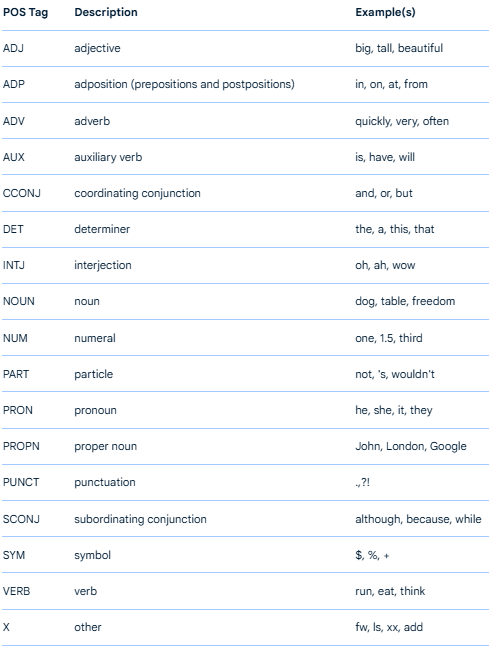

In [17]:
def pos_tag(tokens):
    return nltk.pos_tag(tokens, tagset='universal')

tagged_reviews = tokenized_reviews.apply(pos_tag)

0    [(electra, ADJ), (glide, NOUN), (blue, NOUN), ...
1    [(extremely, ADV), (powerful, ADJ), (film, NOU...
2    [(going, VERB), (lie, ADV), (despite, ADP), (l...
3    [(one, NUM), (first, ADJ), (best, ADV), (music...
4    [(rank, NOUN), (opera, NOUN), (one, NUM), (bet...
Name: review, dtype: object

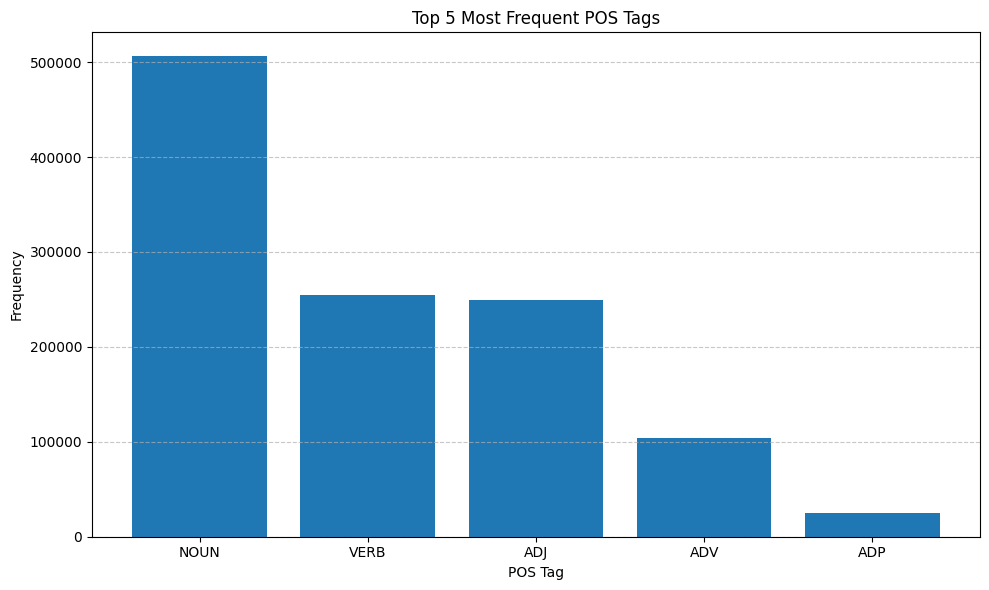

In [ ]:
# visualize the 5 most frequent POS Tags
all_tags = [tag for review in tagged_reviews for (_, tag) in review]

tag_counts = Counter(all_tags)
top_5_tags = tag_counts.most_common(5)

tags, counts = zip(*top_5_tags)

plt.figure(figsize=(10, 6))
plt.bar(tags, counts)
plt.title("Top 5 Most Frequent POS Tags")
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Words Embedding
I'll send the tokens after doing lemmatization - our main goal is capture the sentiment of a review, having "loved" and "loving" as seperate tokens is unnecessary for that, we can just keep the root form "love".

I'll use "skip-gram" because it is should be working better with rare sentiment words - for example "horrific", "joyful", "delighted" and more..
Because skip-gram tries to predict the context words for each target word, even if a word is rare, it gets to train multiuple context pairs.
#### Example:
Sentence: “The movie was astounding and deeply emotional.”
Skip-Gram creates pairs like: ("astounding", "was"), ("astounding", "and"), ("astounding", "deeply")
So, despite being rare, "astounding" is updated several times per sentence, using meaningful nearby words.

In [ ]:
w2v_model = Word2Vec(
    sentences=lemmatized_reviews.tolist(),
    vector_size=100,     # Size of word embeddings
    window=5,            # Context window size
    min_count=2,         # The minimum frequency a word must have to be included in the vocabulary
    workers=4,           # Use multiprocessing
    sg=1                 # Use Skip-Gram (1) or CBOW (0)
)

In [22]:
# print the top 5 frequent words vectors
for word in w2v_model.wv.index_to_key[:3]:
    print(f"{word}: {w2v_model.wv[word]}")

movie: [-0.2509324   0.19501327  0.10988303  0.26904315 -0.05670014 -0.24956465
  0.28142864  0.6189923  -0.00809289 -0.03661086 -0.05292897 -0.23317832
 -0.10317402  0.36830875 -0.13236494  0.10942698  0.01031546 -0.11807141
 -0.34973946 -0.44747514  0.16477178  0.05482848  0.6427557  -0.3671537
  0.24108192  0.19846095  0.04028486  0.07325754 -0.42993304  0.15342222
  0.48904765 -0.0404547   0.313234   -0.37668148 -0.15697522  0.31396633
  0.24008428 -0.13711058 -0.12260175 -0.5517862   0.05019245 -0.25269637
 -0.37159336  0.01062811  0.10304985  0.08618031 -0.04142675 -0.11424953
  0.23115605  0.0033699   0.3236219  -0.02600036 -0.2137841   0.08902913
  0.23995599 -0.01910646  0.33885264  0.14182806 -0.2600929  -0.06947277
 -0.07553294 -0.22421582 -0.00272113 -0.36651292 -0.43056393  0.4707114
  0.1734423   0.12478475 -0.21979642  0.4451108   0.05091359  0.43541566
 -0.01203403  0.05179294  0.48042983  0.31932995  0.21560049 -0.140253
  0.00364009 -0.01347798 -0.2874996  -0.02440983

## Sentiment Analysis with LSTM
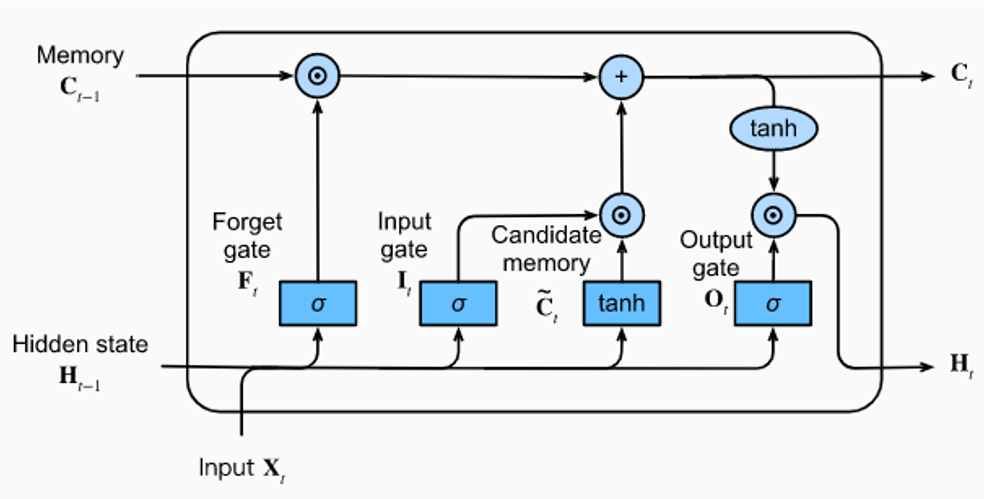
- LSTM is a type of Recurrent Neural Network (RNN) designed to handle sequential data, making it ideal for natural language tasks.
- It captures long-range dependencies in text, such as how early words in a sentence influence later sentiment.
- I'll enhance the LSTM model by using a pretrained embedding matrix generated by the Skip-Gram variant of Word2Vec, this setup provides the LSTM with context-aware vector representations from the beginning which might lead to a more accurate sentiment prediction.

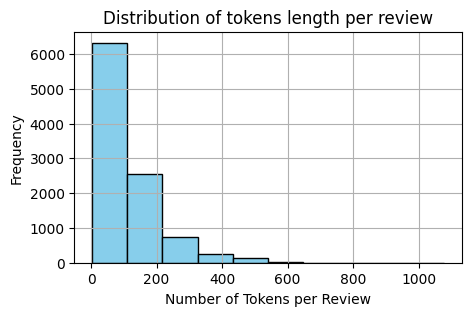

In [23]:
# Calculate token lengths - for the max length
token_lens = [len(token) for token in lemmatized_reviews]

# Plot the distribution
plt.figure(figsize=(5, 3))
plt.hist(token_lens, color='skyblue', edgecolor='black')
plt.title("Distribution of tokens length per review")
plt.xlabel("Number of Tokens per Review")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

I analyzed the distribution of tokens length per review. This helps determine an appropriate padding length for model training. It is crucial because the chosen padding length directly impacts the input representation used during model training. I decided to set the max length to 200 for both LSTM and BERT as it trades off between resources used and accuracy.

In [24]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def prepare_lstm_data(reviews, sentiments, maxlen=200, test_size=0.2):
    labels = LabelEncoder().fit_transform(sentiments)
    texts = [' '.join(tokens) for tokens in reviews]

    tokenizer = Tokenizer(oov_token="<UNK>")
    tokenizer.fit_on_texts(texts)

    sequences = tokenizer.texts_to_sequences(texts)
    X_pad = pad_sequences(sequences, maxlen=maxlen, padding='post')
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_pad, labels, test_size=test_size, stratify=labels, random_state=42
    )
    
    return tokenizer, X_train, X_test, y_train, y_test

2025-07-08 18:21:54.252061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751998914.472306      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751998914.534013      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [26]:
def create_embedding_matrix(tokenizer, w2v_model, embedding_dim):
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1

    embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))
    
    for word, i in word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
    
    return embedding_matrix, vocab_size

In [ ]:
def build_and_train_model(X_train, y_train, X_test, y_test, vocab_size, embedding_matrix, embedding_dim):
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  trainable=True),
        LSTM(128),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=5,
        batch_size=64
    )
    
    return model, history

In [28]:
lstm_tokenizer, X_train, X_test, y_train, test_y = prepare_lstm_data(lemmatized_reviews, balanced_reviews['sentiment'])
embedding_matrix, vocab_size = create_embedding_matrix(lstm_tokenizer, w2v_model, w2v_model.vector_size)
lstm_model, lstm_history = build_and_train_model(X_train, y_train, X_test, test_y, vocab_size, embedding_matrix, w2v_model.vector_size)

I0000 00:00:1751998927.149770      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       4,990,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,990,100 (19.04 MB)

 Trainable params: 4,990,100 (19.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1751998931.482527     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4945 - loss: 0.7029 - val_accuracy: 0.5185 - val_loss: 0.6866
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5300 - loss: 0.6765 - val_accuracy: 0.5150 - val_loss: 0.6938
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5810 - loss: 0.6456 - val_accuracy: 0.7270 - val_loss: 0.5749
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6906 - loss: 0.5782 - val_accuracy: 0.8260 - val_loss: 0.4281
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8653 - loss: 0.3609 - val_accuracy: 0.8315 - val_loss: 0.4027


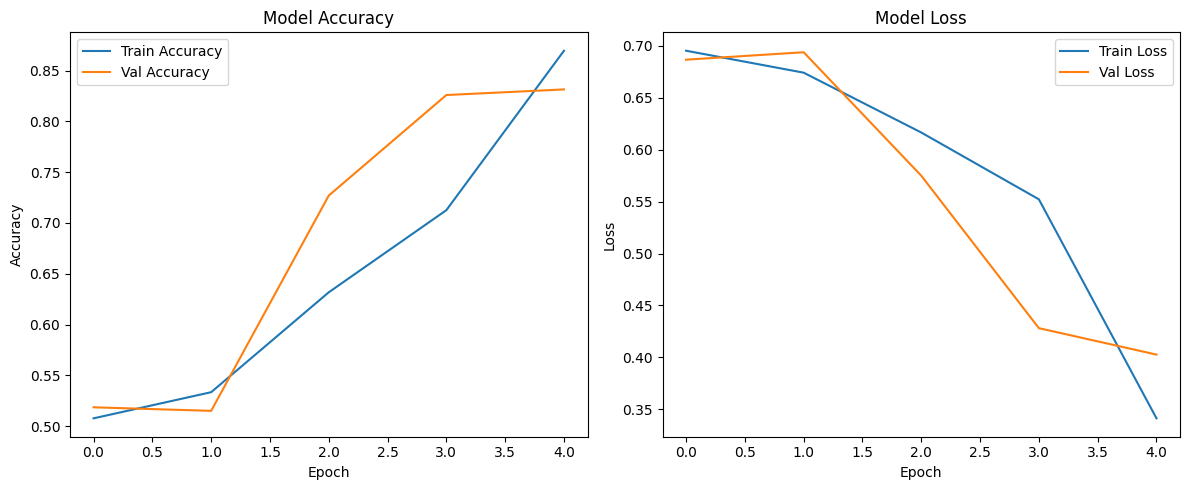

In [29]:
plot_training_history(lstm_history)

## Sentiment Analysis with Transformer (BERT)
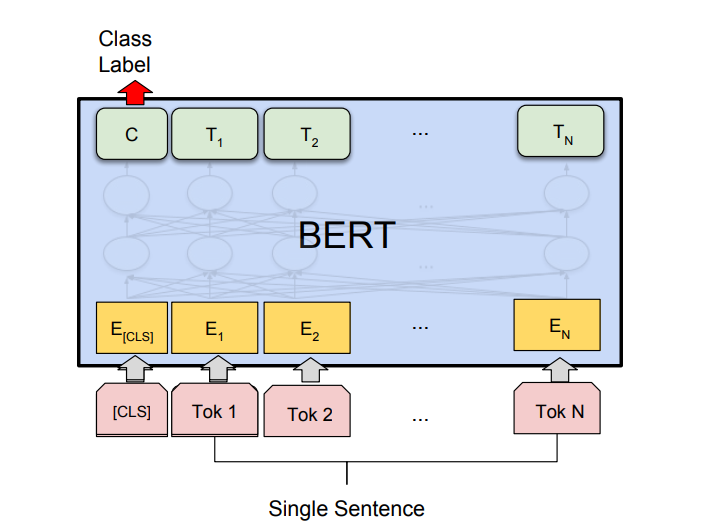

BERT relies on a Transformer (the attention mechanism that learns contextual relationships between words in a text). A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. The input to the encoder for BERT is a sequence of tokens, which are first converted into vectors and then processed in the neural network. But before processing can start, BERT needs the input to be massaged and decorated with some extra metadata:

1. Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.

2. Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.

3. Positional embeddings: A positional embedding is added to each token to indicate its position in the sentence.

In [ ]:
def prepare_bert_data(texts, sentiments, tokenizer_name="distilbert-base-uncased", max_length=200, batch_size=32):
    labels = LabelEncoder().fit_transform(sentiments)
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2, stratify=labels, random_state=42
    )

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=max_length)
    test_encodings = tokenizer(X_test, truncation=True, padding='max_length', max_length=max_length)

    train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))\
                                   .shuffle(len(y_train)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))\
                                  .batch(batch_size)
    
    return train_dataset, test_dataset, tokenizer, y_test

In [ ]:
def build_bert_model(tokenizer_name="distilbert-base-uncased", num_labels=2, train_dataset=None, epochs=2):
    steps_per_epoch = len(train_dataset)
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1 * num_train_steps)

    optimizer, _ = create_optimizer(
        init_lr=2e-5,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
    )

    model = TFDistilBertForSequenceClassification.from_pretrained(tokenizer_name, num_labels=num_labels)

    model.compile(
        optimizer=optimizer,
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    model.summary()
    return model

In [32]:
def train_bert_model(model, train_dataset, test_dataset, epochs=2):
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=epochs
    )
    return history

In [33]:
texts = balanced_reviews['review'].tolist()
sentiments = balanced_reviews['sentiment']

In [34]:
train_dataset, test_dataset, bert_tokenizer, y_test = prepare_bert_data(texts, sentiments)
bert_model = build_bert_model(train_dataset=train_dataset)
bert_history = train_bert_model(bert_model, train_dataset, test_dataset)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2


I0000 00:00:1751999206.600703     131 service.cc:148] XLA service 0x7eb672504ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751999206.601270     131 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751999206.785115     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 129s 411ms/step - loss: 0.4058 - accuracy: 0.8009 - val_loss: 0.2861 - val_accuracy: 0.8825
Epoch 2/2
250/250 [==============================] - 99s 398ms/step - loss: 0.2145 - accuracy: 0.9176 - val_loss: 0.2813 - val_accuracy: 0.8940


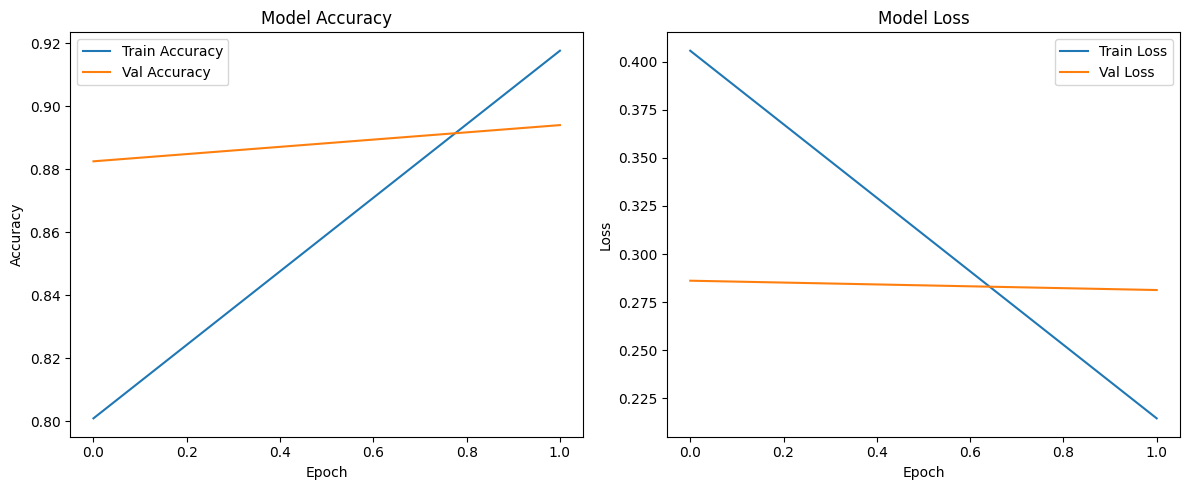

In [36]:
plot_training_history(bert_history)

# Models performence comparison (confusion matrix, f1, accuracy)

In [ ]:
def lstm_evaluate(model, X, y, thresh=0.5):
    probs = model.predict(X).ravel()
    preds = (probs > thresh).astype(int)
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds)
    print("Accuracy:", acc)
    print("F1 score:", f1)
    ConfusionMatrixDisplay.from_predictions(y, preds, cmap="Blues", display_labels=["Negative review", "Positive review"])
    plt.title("LSTM Confusion Matrix")
    plt.show()
    return acc, f1

def bert_evaluate(model, dataset, y_true, thresh=0.5, title="BERT"):
    logits = model.predict(dataset)["logits"]
    probs = tf.nn.softmax(logits, axis=1).numpy()[:, 1]
    preds = (probs > thresh).astype(int)
    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    print("Accuracy:", acc)
    print("F1 score:", f1)
    ConfusionMatrixDisplay.from_predictions(y_true, preds, cmap="Blues", display_labels=["Negative review", "Positive review"])
    plt.title(f"{title} Confusion Matrix")
    plt.show()
    return acc, f1

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.8315
F1 score: 0.8486753480017961


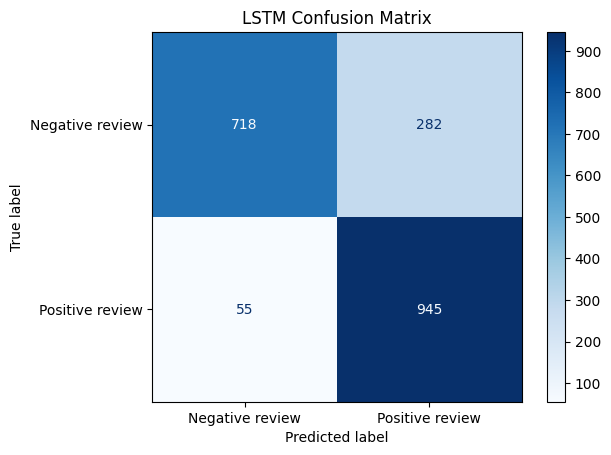

63/63 [==============================] - 10s 124ms/step
Accuracy: 0.894
F1 score: 0.8976833976833978


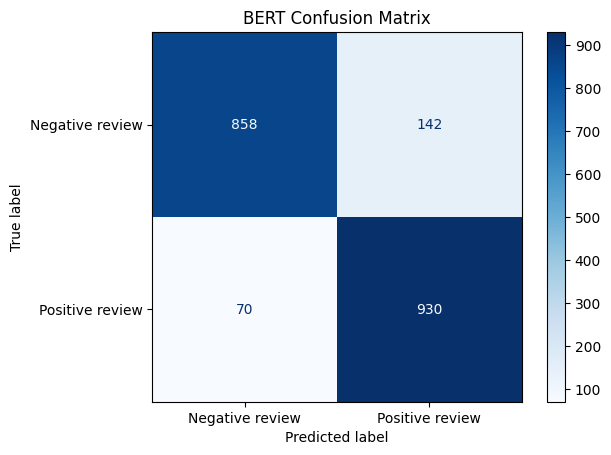

In [38]:
lstm_acc, lstm_f1 = lstm_evaluate(lstm_model, X_test, test_y)
bert_acc, bert_f1 = bert_evaluate(bert_model, test_dataset, y_test)

### Explanation:
As we can see, the BERT model is slightly better on each of the confusion matrix labels.
especially we can see that it has much less 'False Negatives' then the LSTM: 142 vs 282.

Although, the LSTM got a quite impressive results and it took much less resources (computing time) to train it.
Its also important to notice that i have sended the word2vec static embedding matrix to the LSTM while the BERT is based on its own contexualized tokenizer and encoder.

# Models performence evaluation comparison after shuffling the data input order

In [ ]:
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)
lstm_model_shuffled, lstm_history_shuffled = build_and_train_model(
    X_train_shuffled, y_train_shuffled, X_test, test_y, vocab_size, embedding_matrix, w2v_model.vector_size
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       4,990,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,990,100 (19.04 MB)

 Trainable params: 4,990,100 (19.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5102 - loss: 0.7035 - val_accuracy: 0.5085 - val_loss: 0.6890
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5312 - loss: 0.6731 - val_accuracy: 0.5415 - val_loss: 0.6774
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5592 - loss: 0.6467 - val_accuracy: 0.6935 - val_loss: 0.6290
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7744 - loss: 0.5267 - val_accuracy: 0.7745 - val_loss: 0.5524
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7011 - loss: 0.5729 - val_accuracy: 0.7595 - val_loss: 0.5556


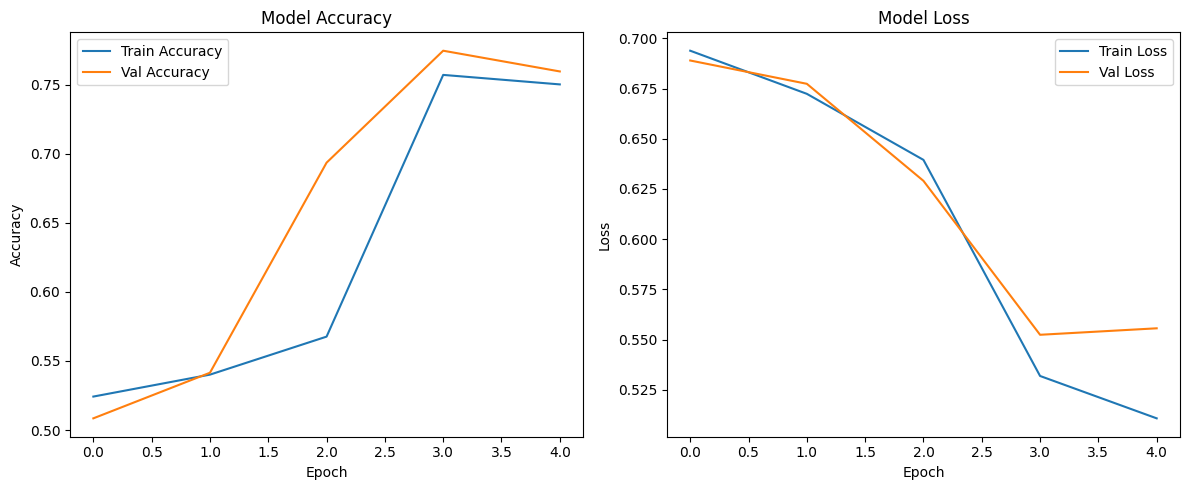

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.7595
F1 score: 0.7902311382468383


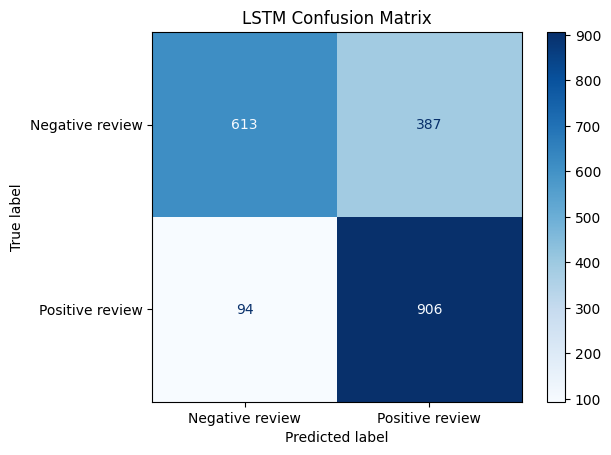

In [40]:
plot_training_history(lstm_history_shuffled)
lstm_shuffled_acc, lstm_shuffled_f1 = lstm_evaluate(lstm_model_shuffled, X_test, y_test)

In [41]:
# BERT
train_dataset_shuffled = train_dataset.shuffle(len(train_dataset))
bert_model_shuffled = build_bert_model(train_dataset=train_dataset_shuffled)
bert_history_shuffled = train_bert_model(bert_model_shuffled, train_dataset_shuffled, test_dataset)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
250/250 [=========================

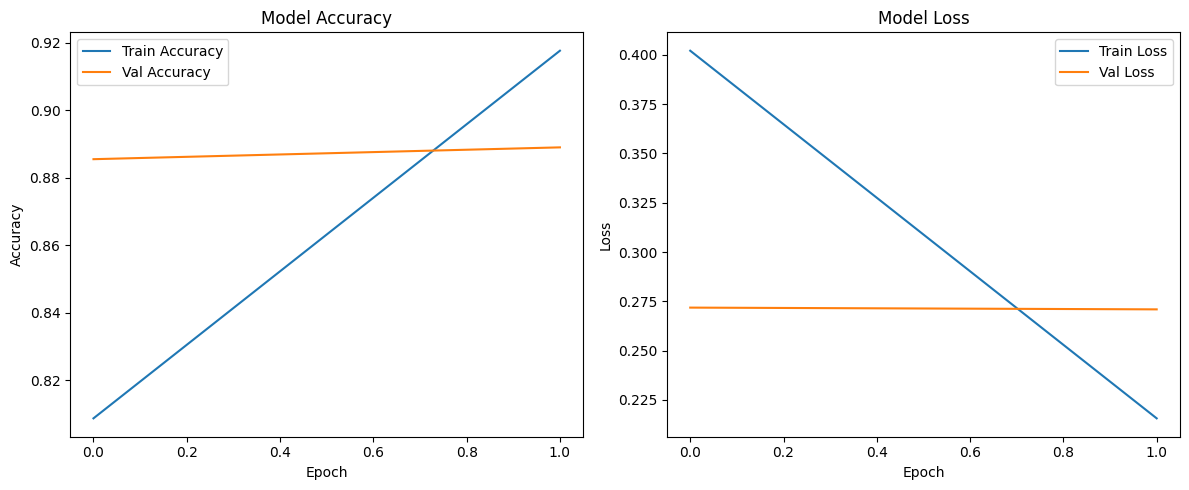

63/63 [==============================] - 10s 124ms/step
Accuracy: 0.889
F1 score: 0.8916015625


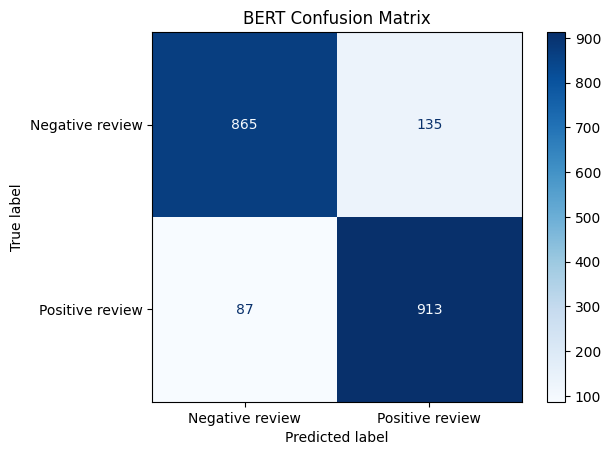

In [42]:
plot_training_history(bert_history_shuffled)
bert_shuffled_acc, bert_shuffled_f1 = bert_evaluate(bert_model_shuffled, test_dataset, y_test)

# Final Results Conclusions
### Is the training input order affected LSTM VS BERT models performance?

In [43]:
def _plot_metric_subplot(ax, x, lstm_scores, bert_scores, versions, title, ylabel):
    bar_width = 0.35
    bars1 = ax.bar(x - bar_width/2, lstm_scores, width=bar_width, label='LSTM', color='#FBDB93')
    bars2 = ax.bar(x + bar_width/2, bert_scores, width=bar_width, label='BERT', color='#732255')
    
    ax.set_xticks(x)
    ax.set_xticklabels(versions, fontsize=11)
    ax.set_ylim(0, 1.1)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    for bar_group in [bars1, bars2]:
        for bar in bar_group:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2,
                    height + 0.01,
                    f"{height:.3f}",
                    ha='center', va='bottom',
                    fontsize=9)

def plot_model_comparison(versions, lstm_acc, lstm_f1, bert_acc, bert_f1):
    x = np.arange(len(versions))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    _plot_metric_subplot(axs[0], x, lstm_acc, bert_acc, versions,
                         title="Accuracy: LSTM vs BERT", ylabel="Accuracy")

    _plot_metric_subplot(axs[1], x, lstm_f1, bert_f1, versions,
                         title="F1 Score: LSTM vs BERT", ylabel="F1 Score")

    axs[0].legend()
    axs[1].legend()
    plt.tight_layout()
    plt.show()

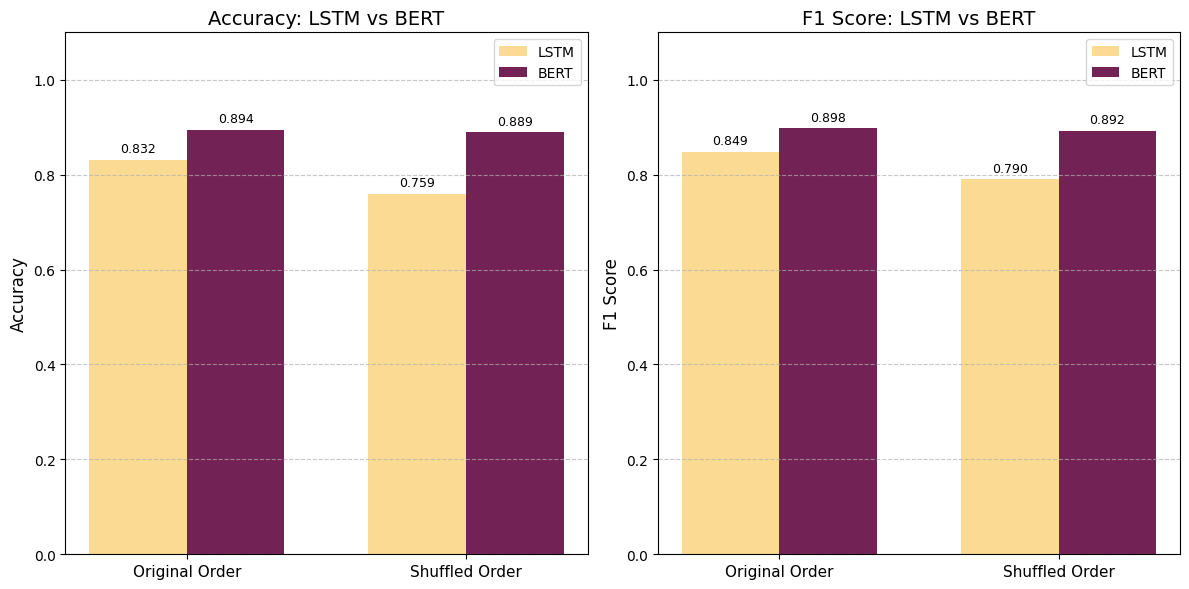

In [44]:
plot_model_comparison(
    versions=['Original Order', 'Shuffled Order'],
    lstm_acc=[lstm_acc, lstm_shuffled_acc],
    lstm_f1=[lstm_f1, lstm_shuffled_f1],
    bert_acc=[bert_acc, bert_shuffled_acc],
    bert_f1=[bert_f1, bert_shuffled_f1]
)

# Explanation
#### As we can see from the results, changing the training input order affected the LSTM model by lowering its accuracy after shuffling the training order in almost 10% and its f1 score in 7%.<br> That compared to the BERT model that its scores almost didnt changed between the original and shuffled training data.
# Why?
#### Actually after running the same tests few times, i have got a mixed accuracy between the LSTM original vs shuffled compared to the BERT consistent accuracy. Evetually i came to the conclusion that i cannot tell if it is exactly the training order that affect accuracy or any other stochastic elements involved in LSTM training such as random inital weights, random mini-batch for each training step from the dataset and more.. <br>But i do can tell that LSTM fluctuate much more between trainings and it might be related also to the way it works - processing data sequenteually and capturing long term dependecies.<br> 
#### While BERT is already pretrained on massive corpora (e.g., BooksCorpus, Wikipedia), so it starts from strong language understanding and doesn't rely as much on the order of new training input. Therefore, shuffling the training examples has little to no effect on BERT’s performance.

## Testing the models manually:

In [49]:
def predict_lstm_review(review, model, tokenizer, maxlen=200, threshold=0.5):
    review_tokens = review.lower().split() 
    seq = tokenizer.texts_to_sequences([' '.join(review_tokens)])
    padded = pad_sequences(seq, maxlen=maxlen, padding='post')
    
    prob = model.predict(padded).ravel()[0]
    label = "Positive" if prob > threshold else "Negative"
    
    return f"{label} ({prob:.3f})"

def predict_bert_review(review, model, tokenizer, maxlen=200, threshold=0.5):
    inputs = tokenizer(
        review,
        return_tensors="tf",
        truncation=True,
        padding='max_length',
        max_length=maxlen
    )

    logits = model(inputs).logits
    prob = tf.nn.softmax(logits, axis=1).numpy()[0, 1]
    label = "Positive" if prob > threshold else "Negative"

    return f"{label} ({prob:.3f})"

In [53]:
sample1 = "I loved the performance!"
sample2 = "This movie was realy not good!"
sample3 = "Oh, this movie was a masterpiece... of boredom."
sample4 = "The movie tried so hard to be clever, it ended up being exhausting"
samples = [sample1, sample2, sample3, sample4]

In [54]:
def compare_models_predictions(samples, lstm_models, bert_models, lstm_tokenizer, bert_tokenizer):
    for i, sample in enumerate(samples, 1):
        print(f"\n=== Sample {i}: \"{sample}\" ===")

        # LSTM predictions
        lstm_pred_orig = predict_lstm_review(sample, model=lstm_models[0], tokenizer=lstm_tokenizer)
        lstm_pred_shuf = predict_lstm_review(sample, model=lstm_models[1], tokenizer=lstm_tokenizer)
        print(f"[LSTM] Original: {lstm_pred_orig} | Shuffled: {lstm_pred_shuf}")

        # BERT predictions
        bert_pred_orig = predict_bert_review(sample, model=bert_models[0], tokenizer=bert_tokenizer)
        bert_pred_shuf = predict_bert_review(sample, model=bert_models[1], tokenizer=bert_tokenizer)
        print(f"[BERT] Original: {bert_pred_orig} | Shuffled: {bert_pred_shuf}")

In [55]:
compare_models_predictions(
    samples=samples,
    lstm_models=(lstm_model, lstm_model_shuffled),
    bert_models=(bert_model, bert_model_shuffled),
    lstm_tokenizer=lstm_tokenizer,
    bert_tokenizer=bert_tokenizer
)


=== Sample 1: "I loved the performance!" ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[LSTM] Original: Positive (0.911) | Shuffled: Positive (0.623)
[BERT] Original: Positive (0.967) | Shuffled: Positive (0.980)

=== Sample 2: "This movie was realy not good!" ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[LSTM] Original: Positive (0.558) | Shuffled: Negative (0.482)
[BERT] Original: Negative (0.022) | Shuffled: Negative (0.025)

=== Sample 3: "Oh, this movie was a masterpiece... of boredom." ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[LSTM] Original: Positive (0.793) | Shuffled: Negative (0.422)
[BERT] Original: Positive (0.652) | Shuffled: Positive (0.727)

=== Sample 4: "The movie tried so hard to be clever, it ended up being exhausting" ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[LSTM] Original: Positive (0.931) | Shuffled: Positive (0.685)


### As we can see, in general both of the models worked well for a clear sentiment review, mostly failed for a very non clear semantically reviews, the final one might show the superiority of BERT over LSTM for that task.

# Resources
- https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
- https://huggingface.co/blog/bert-101 
- https://www.geeksforgeeks.org/machine-learning/what-is-sentiment-analysis/